In [22]:
import sys
sys.path.append("..")

import torch
import numpy as np
import matplotlib.pyplot as plt
from einops import rearrange, reduce
from tqdm import tqdm, trange
from torch.nn import functional as F
from utils.download_mnist import modified_mnist_dataloader_test, modified_mnist_dataloader_train, mnist_dataloader_train
from assembler import get_config, get_config_ebm, make_energy_model
from utils.config import show 
from experiment import OptiEBM

path = !cd .. && pwd
path = path[0]

def plotable(img):
    return rearrange(img, "b c h w -> (b c h) w ").cpu().detach().numpy()

def make_adaptive_experiment(config):
    ebm = make_energy_model(config, path=path)
    emb = ebm.to("cuda")
    adapt = OptiEBM(config, ebm)
    return adapt

def get_model_config(model_name):
    dataset, model, sampling, task = model_name.split("/")
    name = f"{sampling}/{task}"
    config = get_config(get_config_ebm, dataset, model, name, path=path)
    return config

def pixelwise_varaince(imgs):
    ex = reduce(imgs, "b h w -> h w", "mean")
    ex2 = reduce(imgs**2, "b h w -> h w", "mean")
    return ex2 - ex**2

def reconstruction_error(x_hat, x, reduction="mean"):
    return F.mse_loss(x_hat, x, reduction=reduction)

In [23]:
model_name = "modified_mnist/vae/langvein/inpainting"
config = get_model_config(model_name)

In [24]:
config["exp_params"]["batch_size"] = 1
dm = modified_mnist_dataloader_test(config, path=path)

In [25]:
gen = iter(dm)
x, y = next(gen)
x = x.to("cuda")

In [26]:
config["operator_params"]["size"] = 32

In [27]:
# The idea here is to first take 100 estimation and then take the avg of all 100 different estimate error for a single image

def random_iteration(x):
    adapt = make_adaptive_experiment(config)
    x_tilde = adapt.ebm.operator(x)
    plt.imshow(rearrange(x_tilde.cpu(), "b c h w -> (b c h) w"))
    plt.show()
    out = []
    n_samples = 10
    for i in range(20):
        imgs = torch.zeros(n_samples, 32, 32)
        x_tilde = adapt.ebm.operator(x)
        for num in trange(0, n_samples):
            x_hat = rearrange(adapt.ebm(x_tilde), "b c h w -> (b c) h w")
            imgs[num, : , :] = x_hat
        ri, A = adapt.random_sample(imgs, 10)
        adapt.update_operator(A)
        x_tilde = adapt.ebm.operator(x)
        out.append(torch.max(x_tilde).cpu().detach())
        fig, axs= plt.subplots(1, 2)
        axs[0].imshow(rearrange(x_tilde.cpu(), "b c h w -> (b c h) w"))
        axs[1].imshow(rearrange(x_hat.cpu().detach().numpy(), "c h w -> (c h) w" ))
        plt.show()
    return out

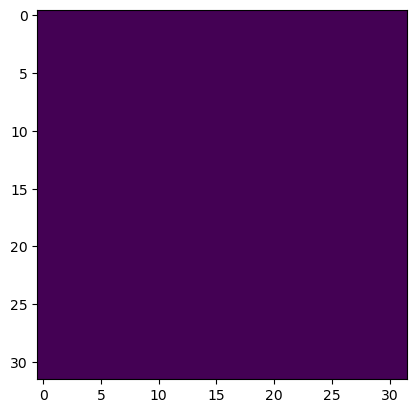

100%|██████████| 10/10 [00:00<00:00, 28.98it/s]


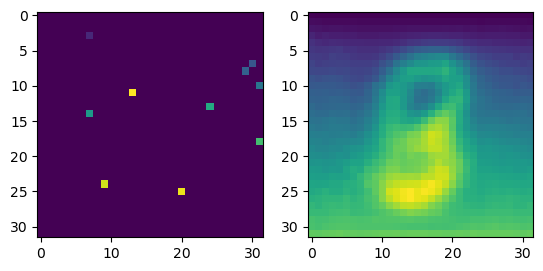

100%|██████████| 10/10 [00:00<00:00, 27.61it/s]


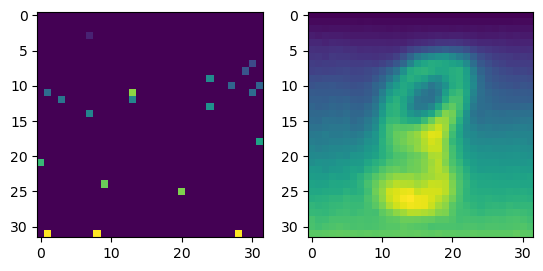

100%|██████████| 10/10 [00:00<00:00, 27.89it/s]


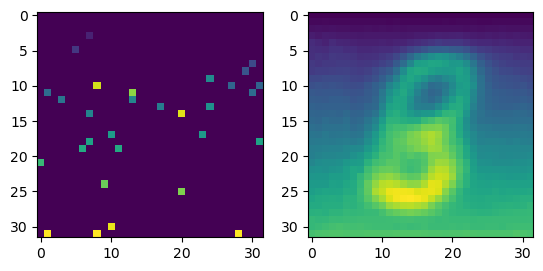

100%|██████████| 10/10 [00:00<00:00, 28.09it/s]


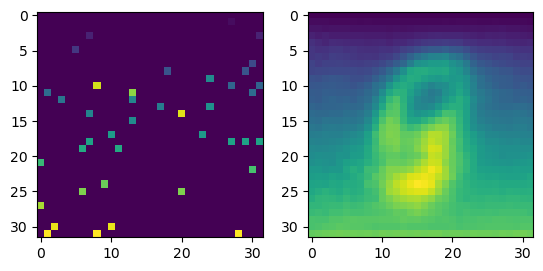

100%|██████████| 10/10 [00:00<00:00, 27.73it/s]


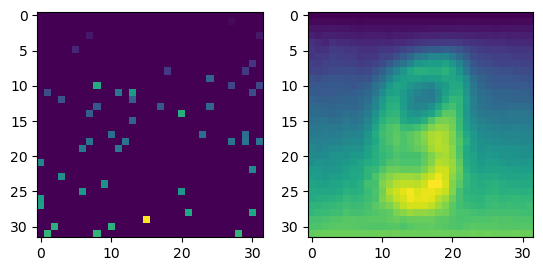

100%|██████████| 10/10 [00:00<00:00, 28.06it/s]


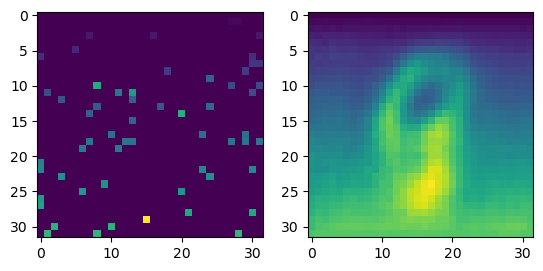

100%|██████████| 10/10 [00:00<00:00, 28.08it/s]


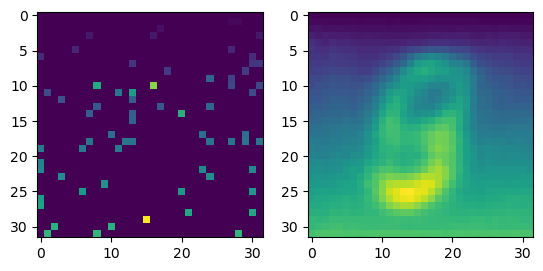

100%|██████████| 10/10 [00:00<00:00, 26.77it/s]


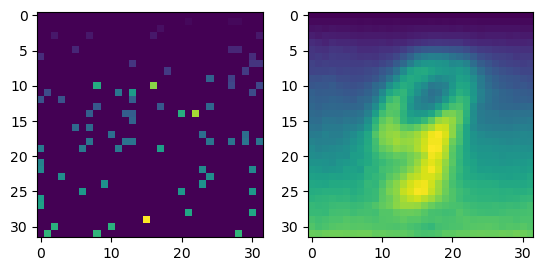

100%|██████████| 10/10 [00:00<00:00, 27.75it/s]


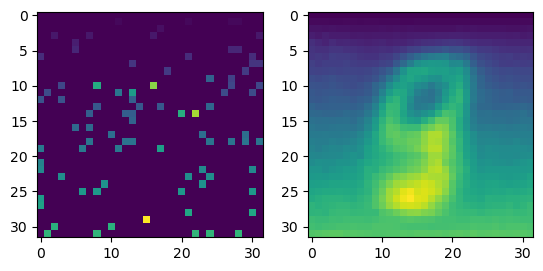

100%|██████████| 10/10 [00:00<00:00, 28.93it/s]


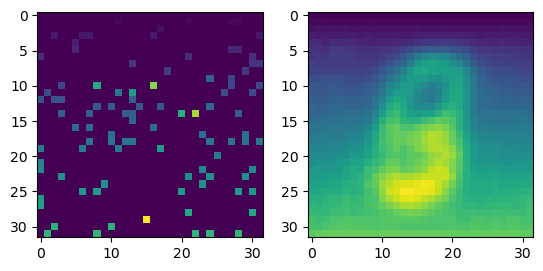

100%|██████████| 10/10 [00:00<00:00, 29.57it/s]


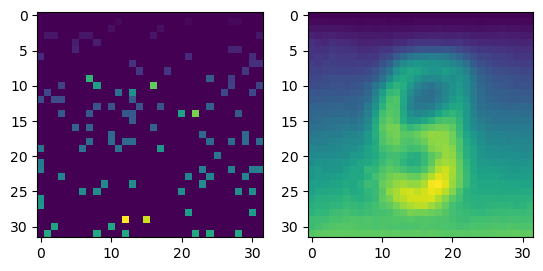

100%|██████████| 10/10 [00:00<00:00, 29.44it/s]


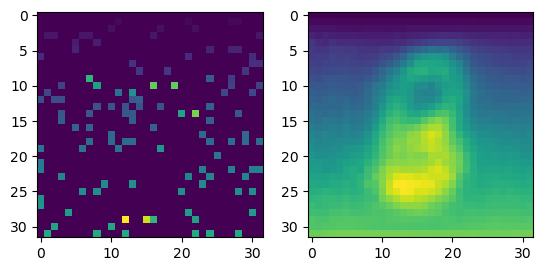

100%|██████████| 10/10 [00:00<00:00, 29.22it/s]


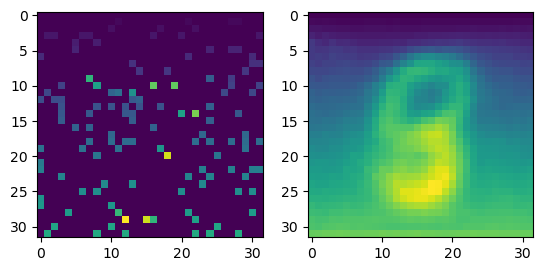

100%|██████████| 10/10 [00:00<00:00, 29.06it/s]


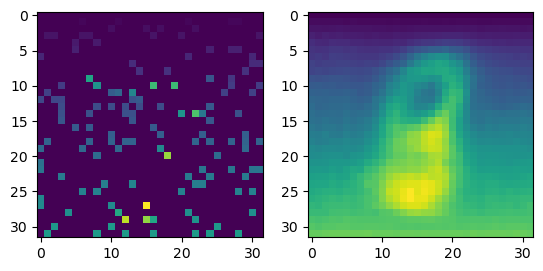

100%|██████████| 10/10 [00:00<00:00, 29.46it/s]


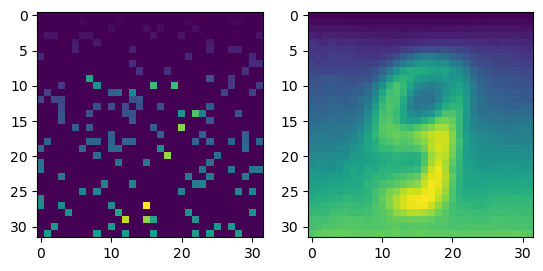

100%|██████████| 10/10 [00:00<00:00, 28.99it/s]


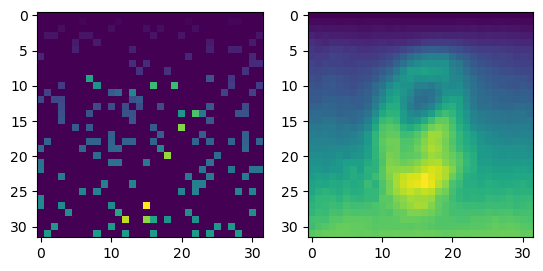

100%|██████████| 10/10 [00:00<00:00, 29.46it/s]


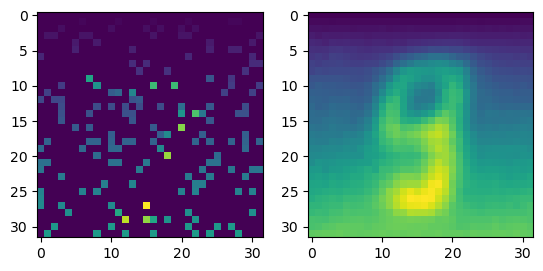

100%|██████████| 10/10 [00:00<00:00, 28.48it/s]


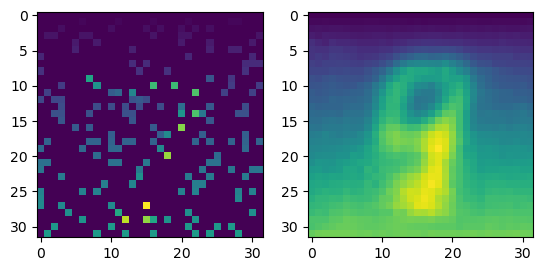

100%|██████████| 10/10 [00:00<00:00, 27.95it/s]


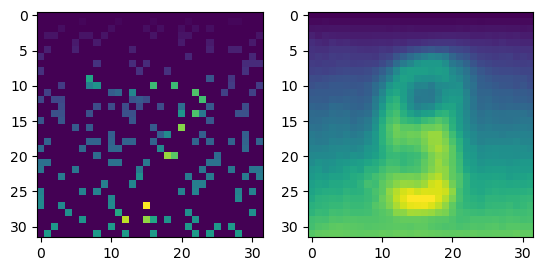

100%|██████████| 10/10 [00:00<00:00, 29.11it/s]


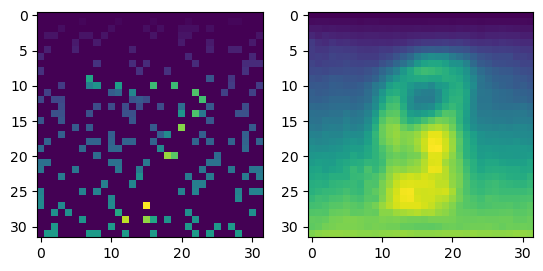

In [28]:
out1 = random_iteration(x)

In [29]:
# The idea here is to first take 100 estimation and then take the avg of all 100 different estimate error for a single image

def thomospon_iteration(x):
    adapt = make_adaptive_experiment(config)
    x_tilde = adapt.ebm.operator(x)
    plt.imshow(rearrange(x_tilde.cpu(), "b c h w -> (b c h) w"))
    plt.show()
    out = []
    n_samples = 10
    for i in range(20):
        imgs = torch.zeros(n_samples, 32, 32)
        x_tilde = adapt.ebm.operator(x)
        for num in trange(0, n_samples):
            x_hat = rearrange(adapt.ebm(x_tilde), "b c h w -> (b c) h w")
            imgs[num, : , :] = x_hat
        ri, A = adapt.thomospon_sample(imgs, 10)
        adapt.update_operator(A)
        x_tilde = adapt.ebm.operator(x)
        out.append(torch.max(x_tilde).cpu().detach())
        fig, axs= plt.subplots(1, 2)
        axs[0].imshow(rearrange(x_tilde.cpu(), "b c h w -> (b c h) w"))
        axs[1].imshow(rearrange(x_hat.cpu().detach().numpy(), "c h w -> (c h) w" ))
        plt.show()
    return out

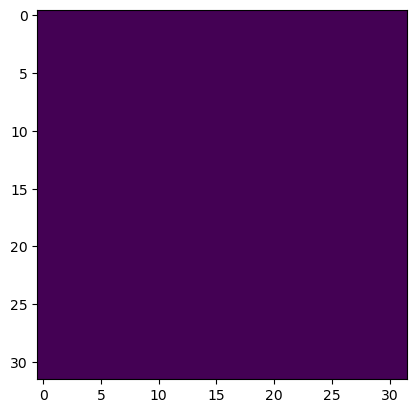

100%|██████████| 10/10 [00:00<00:00, 30.72it/s]


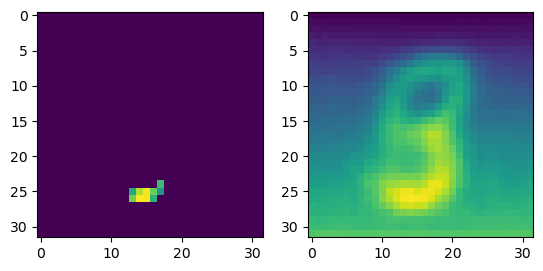

100%|██████████| 10/10 [00:00<00:00, 29.55it/s]


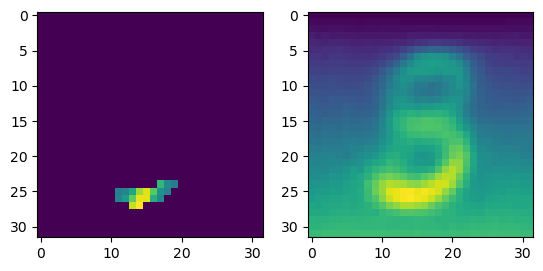

100%|██████████| 10/10 [00:00<00:00, 28.48it/s]


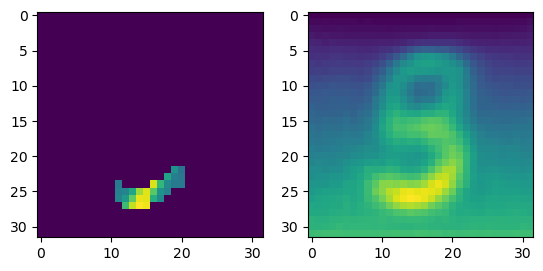

100%|██████████| 10/10 [00:00<00:00, 28.68it/s]


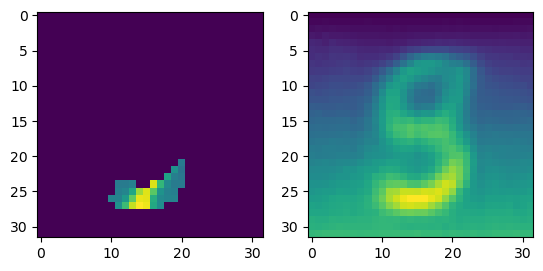

100%|██████████| 10/10 [00:00<00:00, 28.80it/s]


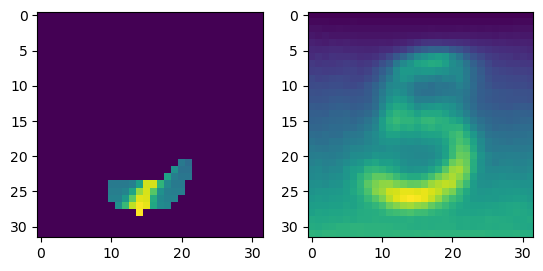

100%|██████████| 10/10 [00:00<00:00, 28.60it/s]


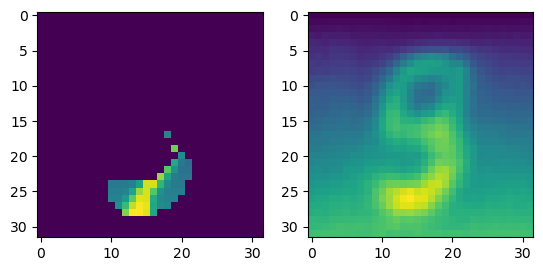

100%|██████████| 10/10 [00:00<00:00, 28.82it/s]


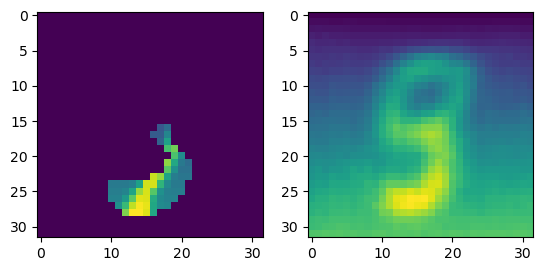

100%|██████████| 10/10 [00:00<00:00, 28.84it/s]


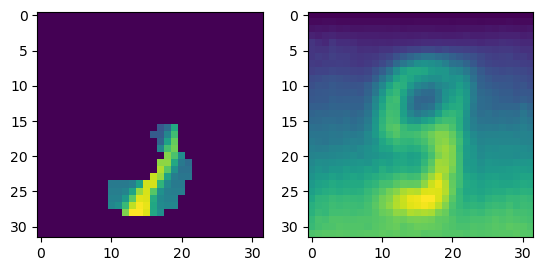

100%|██████████| 10/10 [00:00<00:00, 29.24it/s]


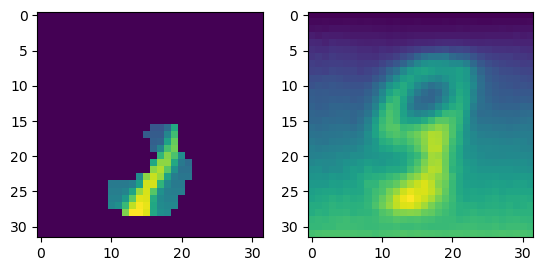

100%|██████████| 10/10 [00:00<00:00, 29.20it/s]


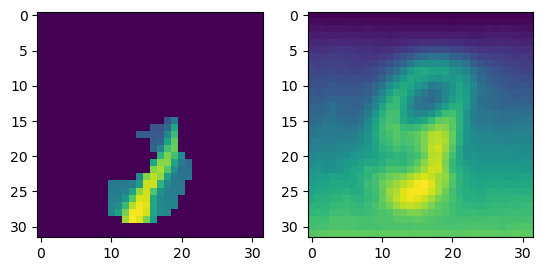

100%|██████████| 10/10 [00:00<00:00, 29.16it/s]


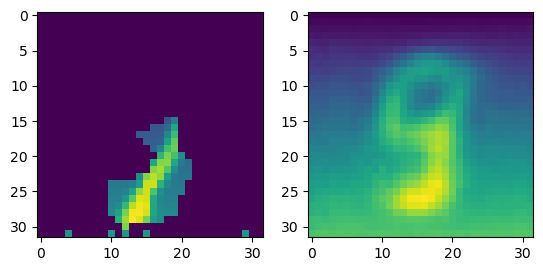

100%|██████████| 10/10 [00:00<00:00, 28.76it/s]


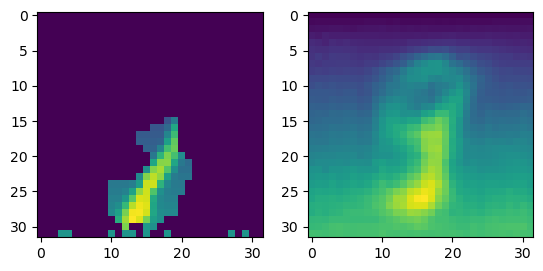

100%|██████████| 10/10 [00:00<00:00, 28.61it/s]


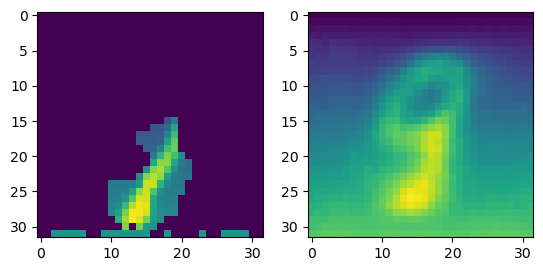

100%|██████████| 10/10 [00:00<00:00, 28.78it/s]


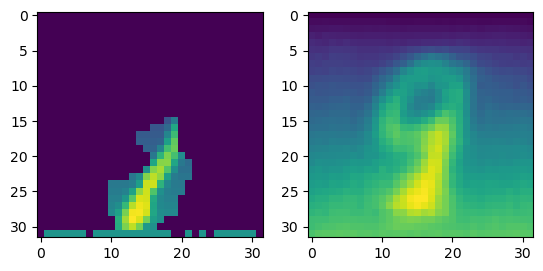

100%|██████████| 10/10 [00:00<00:00, 28.98it/s]


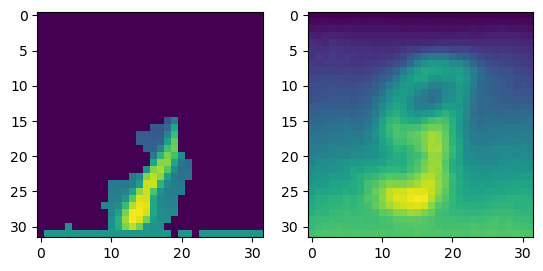

100%|██████████| 10/10 [00:00<00:00, 29.38it/s]


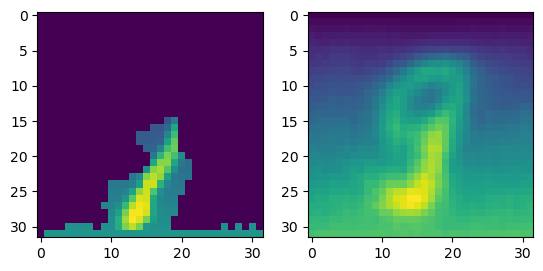

100%|██████████| 10/10 [00:00<00:00, 29.09it/s]


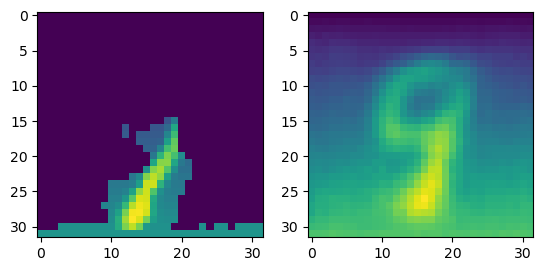

100%|██████████| 10/10 [00:00<00:00, 29.17it/s]


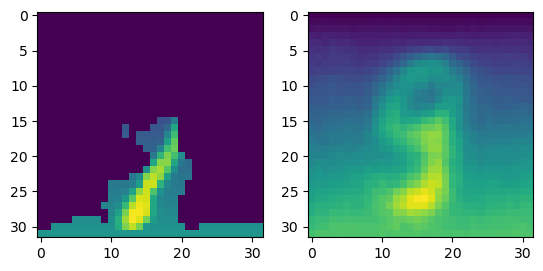

100%|██████████| 10/10 [00:00<00:00, 29.05it/s]


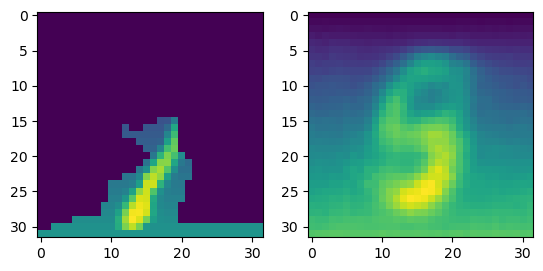

100%|██████████| 10/10 [00:00<00:00, 29.17it/s]


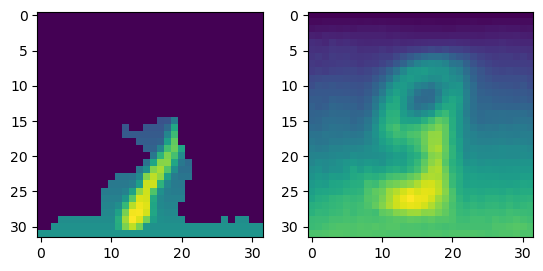

In [30]:
out2 = thomospon_iteration(x)

In [31]:
# The idea here is to first take 100 estimation and then take the avg of all 100 different estimate error for a single image

def ucb_iteration(x):
    adapt = make_adaptive_experiment(config)
    x_tilde = adapt.ebm.operator(x)
    plt.imshow(rearrange(x_tilde.cpu(), "b c h w -> (b c h) w"))
    plt.show()
    out= []
    n_samples = 10
    max_ = 0
    for i in range(20):
        imgs = torch.zeros(n_samples, 32, 32)
        x_tilde = adapt.ebm.operator(x)
        for num in trange(0, n_samples):
            x_hat = rearrange(adapt.ebm(x_tilde), "b c h w -> (b c) h w")
            imgs[num, : , :] = x_hat
        ri, A = adapt.ucb_sample(imgs, k=50, num_pixels_per_samples=10)
        adapt.update_operator(A)
        x_tilde = adapt.ebm.operator(x)
        out.append(torch.max(x_tilde).cpu().detach())
        fig, axs= plt.subplots(1, 2)
        axs[0].imshow(rearrange(x_tilde.cpu(), "b c h w -> (b c h) w"))
        axs[1].imshow(rearrange(x_hat.cpu().detach().numpy(), "c h w -> (c h) w" ))
        plt.show()
    return out

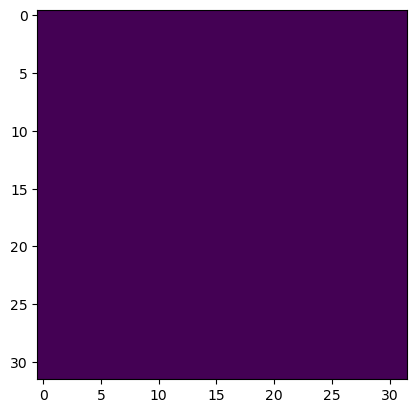

100%|██████████| 10/10 [00:00<00:00, 32.73it/s]


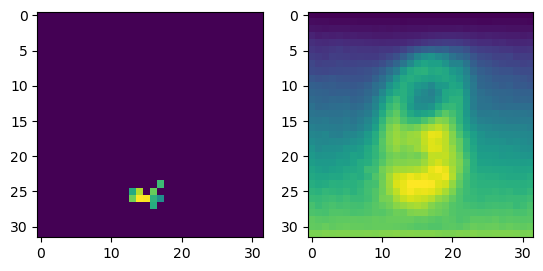

100%|██████████| 10/10 [00:00<00:00, 32.60it/s]


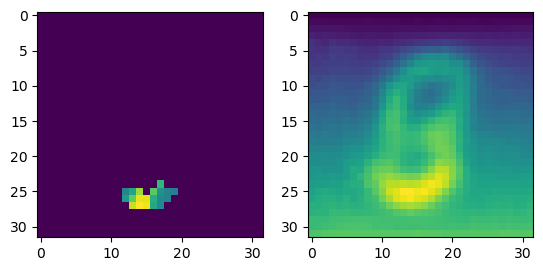

100%|██████████| 10/10 [00:00<00:00, 32.57it/s]


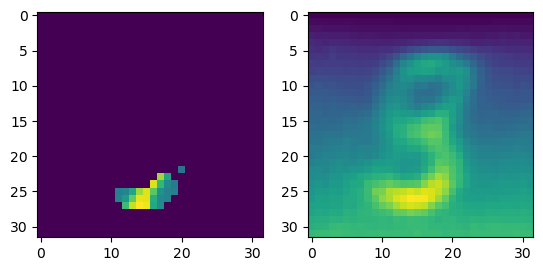

100%|██████████| 10/10 [00:00<00:00, 29.58it/s]


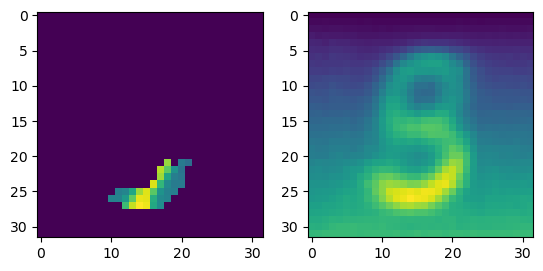

100%|██████████| 10/10 [00:00<00:00, 29.02it/s]


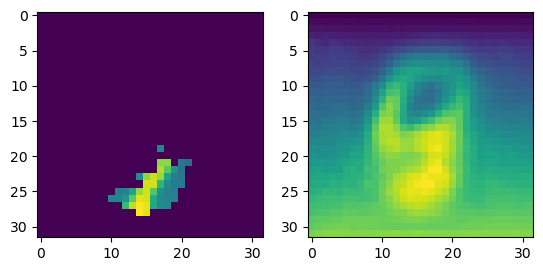

100%|██████████| 10/10 [00:00<00:00, 29.20it/s]


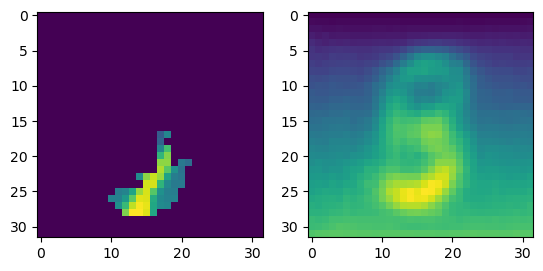

100%|██████████| 10/10 [00:00<00:00, 28.88it/s]


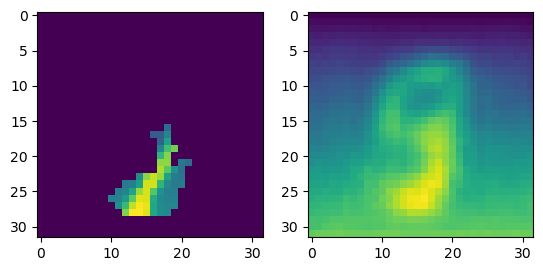

100%|██████████| 10/10 [00:00<00:00, 28.93it/s]


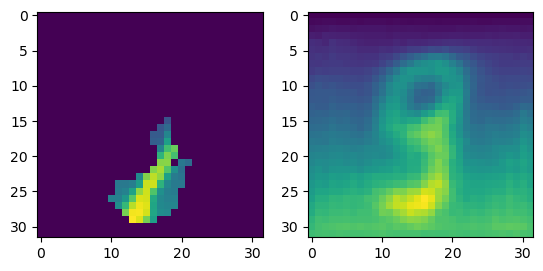

100%|██████████| 10/10 [00:00<00:00, 29.21it/s]


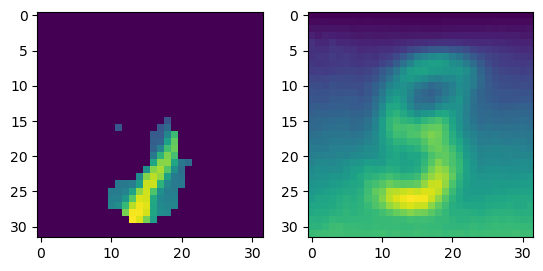

100%|██████████| 10/10 [00:00<00:00, 29.12it/s]


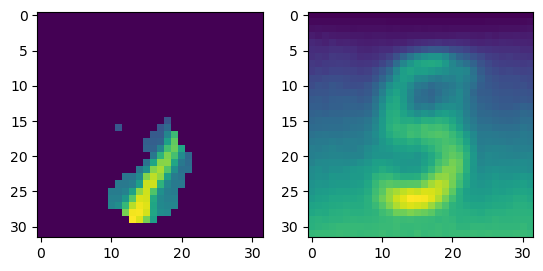

100%|██████████| 10/10 [00:00<00:00, 29.21it/s]


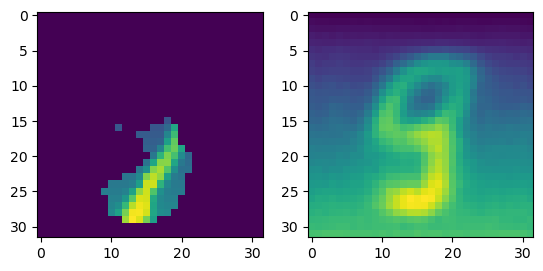

100%|██████████| 10/10 [00:00<00:00, 29.09it/s]


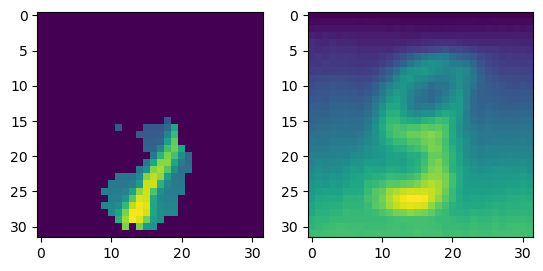

100%|██████████| 10/10 [00:00<00:00, 28.90it/s]


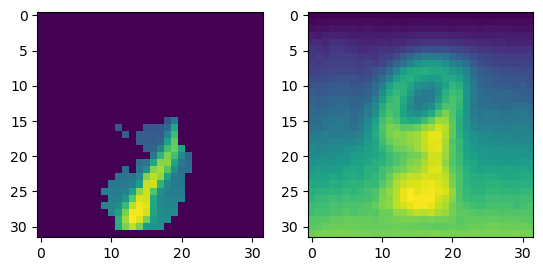

100%|██████████| 10/10 [00:00<00:00, 29.21it/s]


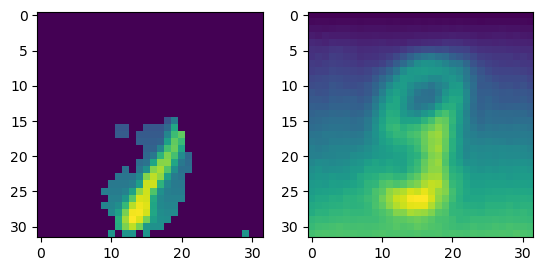

100%|██████████| 10/10 [00:00<00:00, 29.23it/s]


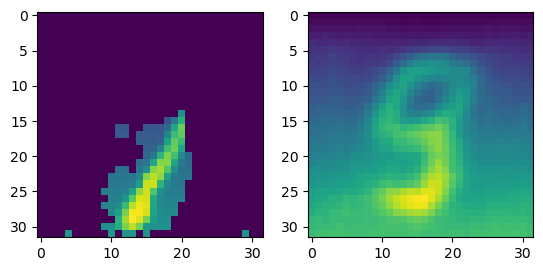

100%|██████████| 10/10 [00:00<00:00, 29.29it/s]


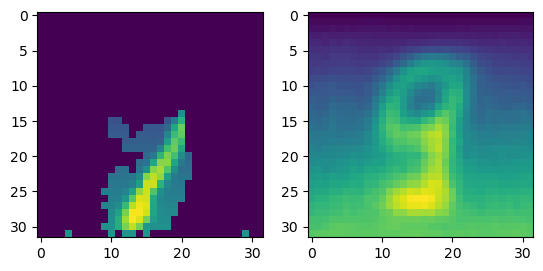

100%|██████████| 10/10 [00:00<00:00, 29.13it/s]


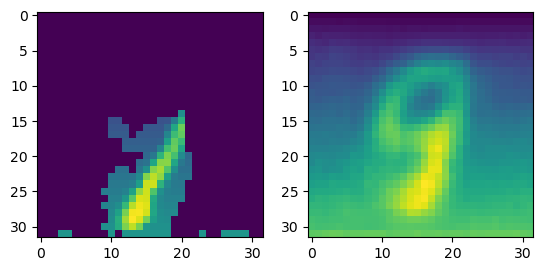

100%|██████████| 10/10 [00:00<00:00, 29.26it/s]


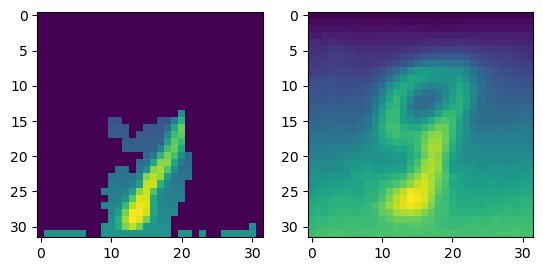

100%|██████████| 10/10 [00:00<00:00, 29.41it/s]


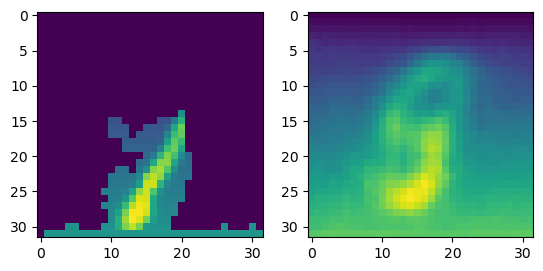

100%|██████████| 10/10 [00:00<00:00, 29.27it/s]


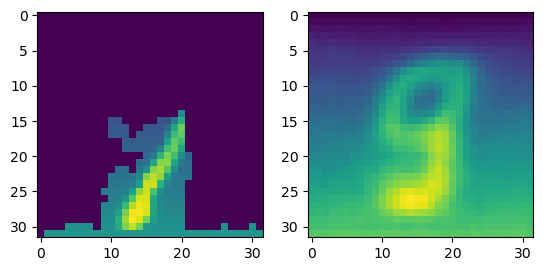

In [32]:
out3= ucb_iteration(x)

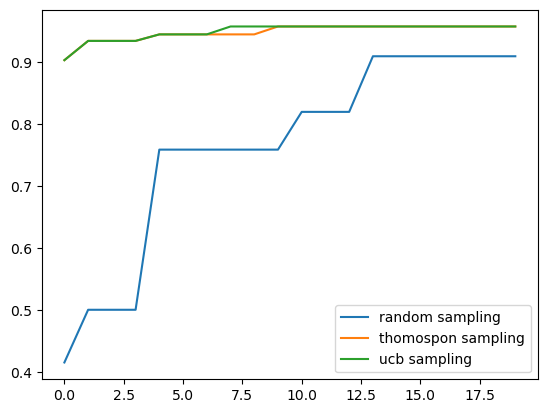

In [33]:
plt.plot(out1)
plt.plot(out2)
plt.plot(out3)
plt.legend(['random sampling','thomospon sampling', 'ucb sampling'])
plt.show()

In [41]:
# The idea here is to first take 100 estimation and then take the avg of all 100 different estimate error for a single image

def ucb_iteration(x):
    adapt = make_adaptive_experiment(config)
    x_tilde = adapt.ebm.operator(x)
    out= []
    n_samples = 10
    for i in range(20):
        imgs = torch.zeros(n_samples, 32, 32)
        x_tilde = adapt.ebm.operator(x)
        for num in range(0, n_samples):
            x_hat = rearrange(adapt.ebm(x_tilde), "b c h w -> (b c) h w")
            imgs[num, : , :] = x_hat
        ri, A = adapt.ucb_sample(imgs, k=50, num_pixels_per_samples=10)
        adapt.update_operator(A)
        x_tilde = adapt.ebm.operator(x)
        out.append(torch.max(x_tilde).cpu().detach().numpy())
    return out

In [42]:
gen = iter(dm)
x, y = next(gen)
x = x.to("cuda")

In [44]:
avg_error_ucb = np.zeros(20, dtype=np.float32)
for t in trange(1, 100):
    x, y = next(gen)
    x = x.to("cuda")
    error = ucb_iteration(x)
    avg_error_ucb = ((t-1)/t)*avg_error_ucb + (1/t)*error[-1]

 41%|████▏     | 41/99 [04:33<06:32,  6.76s/it]

In [ ]:
# The idea here is to first take 100 estimation and then take the avg of all 100 different estimate error for a single image

def thomospon_iteration(x):
    adapt = make_adaptive_experiment(config)
    x_tilde = adapt.ebm.operator(x)
    out = []
    n_samples = 10
    for i in range(20):
        imgs = torch.zeros(n_samples, 32, 32)
        x_tilde = adapt.ebm.operator(x)
        for num in trange(0, n_samples):
            x_hat = rearrange(adapt.ebm(x_tilde), "b c h w -> (b c) h w")
            imgs[num, : , :] = x_hat
        ri, A = adapt.thomospon_sample(imgs, 10)
        adapt.update_operator(A)
        x_tilde = adapt.ebm.operator(x)
        out.append(torch.max(x_tilde).cpu().detach().numpy())
    return out

In [ ]:
gen = iter(dm)
x, y = next(gen)
x = x.to("cuda")

In [ ]:
avg_error_thom = np.zeros(20, dtype=np.float32)
for t in trange(1, 100):
    x, y = next(gen)
    x = x.to("cuda")
    error = thomospon_iteration(x)
    avg_error_thom = ((t-1)/t)*avg_error_thom + (1/t)*error[-1]

In [ ]:
# The idea here is to first take 100 estimation and then take the avg of all 100 different estimate error for a single image

def random_iteration(x):
    adapt = make_adaptive_experiment(config)
    x_tilde = adapt.ebm.operator(x)
    out = []
    n_samples = 10
    for i in range(20):
        imgs = torch.zeros(n_samples, 32, 32)
        x_tilde = adapt.ebm.operator(x)
        for num in trange(0, n_samples):
            x_hat = rearrange(adapt.ebm(x_tilde), "b c h w -> (b c) h w")
            imgs[num, : , :] = x_hat
        ri, A = adapt.random_sample(imgs, 10)
        adapt.update_operator(A)
        x_tilde = adapt.ebm.operator(x)
        out.append(torch.max(x_tilde).cpu().detach().numpy())
    return out

In [ ]:
gen = iter(dm)
x, y = next(gen)
x = x.to("cuda")

In [ ]:
avg_error_random = np.zeros(20, dtype=np.float32)
for t in trange(1, 100):
    x, y = next(gen)
    x = x.to("cuda")
    error = random_iteration(x)
    avg_error_random = ((t-1)/t)*avg_error_random + (1/t)*error[-1]

In [ ]:
plt.plot(avg_error_random)
plt.plot(avg_error_thom)
plt.plot(avg_error_ucb)
plt.legend(['random sampling','thomospon sampling', 'ucb sampling'])
plt.show()